In [ ]:
import csv
csv.field_size_limit(1000000000)
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
from gensim import models
from pprint import pprint
from collections import defaultdict
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LsiModel
from gensim.models import LdaModel, LdaMulticore
!pip install wordcloud
from PIL import Image 

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [ ]:
!pip install -q wordcloud
import wordcloud
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
import nltk

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger') 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
data = pd.read_csv('/content/drive/My Drive/state-of-the-union.csv')
data = data.dropna()
data.reset_index(drop=True)
numpy_data = data.to_numpy()
stopword = pd.read_csv('/content/drive/My Drive/stopwords-en.csv')
stopword = stopword.to_numpy()

In [ ]:
def lsi(corpus_tfidf,dictionary):
  lsi_model = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=250, decay=0.5)
  for topic in lsi_model.print_topics(100):
      print(topic)
def lsi2(corpus_tfidf,dictionary):
  lsi_model = LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30, decay=0.5)
  for topic in lsi_model.print_topics(5,10):
      print(topic)

In [ ]:
def lda(corpus,dictionary):
  lda_model = LdaMulticore(corpus=corpus,
                          id2word=dictionary,
                          random_state=22,
                          num_topics=250,
                          passes=10,
                          chunksize=1000,
                          batch=False,
                          alpha='asymmetric',
                          decay=0.5,
                          offset=64,
                          eta=None,
                          eval_every=0,
                          iterations=100,
                          gamma_threshold=0.001,
                          per_word_topics=True)
  
  lda_model.save('lda_model.model')
  
  for topic in lda_model.print_topics(100):
      print(topic)

In [ ]:
def lda3(corpus,dictionary):
  lda_model = LdaMulticore(corpus=corpus,
                          id2word=dictionary,
                          random_state=22,
                          num_topics=100,
                          passes=10,
                          chunksize=1000,
                          batch=False,
                          alpha='asymmetric',
                          decay=0.5,
                          offset=64,
                          eta=None,
                          eval_every=0,
                          iterations=100,
                          gamma_threshold=0.001,
                          per_word_topics=True)
  # save the model
  lda_model.save('lda_model.model')
  # See the topics
  for topic in lda_model.print_topics(100,20):
      print(topic)

In [ ]:
df = pd.DataFrame(numpy_data,columns=['year','speech'])
df1 = pd.DataFrame(stopword,columns=['words'])
new_row = {'words' : 'a'}
df1= df1.append(new_row, ignore_index=True)

In [ ]:
lemma = WordNetLemmatizer()
df.speech = df.speech.str.replace('\n',' ')
df.speech = df.speech.str.replace('^\w\s',' ')
df.speech = df.speech.str.replace('^A-Za-z',' ')
df.speech = df.speech.str.replace('^a-zA-Z',' ')
df.speech = df.speech.str.replace('  ',' ')

In [ ]:
# define punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~+|'''
i=0
while(i<225):
    # remove punctuation from the string
    punch = ""
    for char in df.speech[i]:
      if char not in punctuations:
          punch = punch + char
    df.speech[i] = punch
    res = ''.join([j for j in df.speech[i] if not j.isdigit()])
    df.speech[i] = res
    i=i+1

In [ ]:
i=0
while(i<225):
    df.speech[i] = nltk.word_tokenize(df.speech[i])
    tokens = [lemma.lemmatize(token) for token in df.speech[i] if token not in stopwords]
    df.speech[i] = ' '.join(tokens) 
    i=i+1

In [ ]:
df.speech[0]

'State Union Address George Washington December FellowCitizens Senate House Representatives In meeting I feel much satisfaction able repeat congratulation favorable prospect continue distinguish public affair The abundant fruit another year blessed country plenty mean flourishing commerce The progress public credit witnessed considerable rise American stock abroad well home revenue allotted national purpose productive beyond calculation regulated This latter circumstance pleasing proof fertility resource assures u increase national respectability credit let add bear honorable testimony patriotism integrity mercantile marine part citizen The punctuality former discharging engagement exemplary In conformity power vested act last session loan florin toward provisional measure previously taken place completed Holland As well celerity filled nature term considering ordinary demand borrowing created situation Europe give reasonable hope execution power may proceed advantage success The Secre

In [ ]:
texts = [[word for word in document.lower().split() if word not in df1]
         for document in df.speech]

from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1] for text in texts]

dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(15386 unique tokens: ['able', 'abridge', 'abroad', 'abundant', 'abundantly']...)


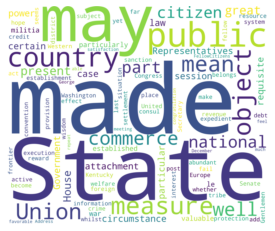

In [ ]:


wordcloud = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='white',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500).generate(df.speech[0])


# Display the generated image:
plt.figure() 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
pprint(dictionary.token2id)
corpus = [dictionary.doc2bow(text) for text in texts]
pprint(corpus)
tfidf = models.TfidfModel(corpus)
for doc in tfidf[corpus]:
    print([[dictionary[id],np.around(freq,decimals=3)]for id,freq in doc])
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    print(doc)

Streaming output truncated to the last 5000 lines.
  (4449, 1),
  (4457, 2),
  (4466, 1),
  (4535, 3),
  (4554, 1),
  (4558, 1),
  (4572, 1),
  (4576, 1),
  (4589, 6),
  (4604, 1),
  (4628, 1),
  (4632, 1),
  (4635, 2),
  (4644, 1),
  (4650, 4),
  (4671, 2),
  (4679, 1),
  (4710, 2),
  (4716, 3),
  (4721, 1),
  (4729, 1),
  (4730, 2),
  (4731, 1),
  (4758, 1),
  (4771, 1),
  (4789, 1),
  (4843, 2),
  (4848, 2),
  (4852, 1),
  (4853, 1),
  (4859, 1),
  (4862, 4),
  (4875, 4),
  (4921, 1),
  (4926, 1),
  (4975, 1),
  (4985, 5),
  (4986, 2),
  (4989, 2),
  (4993, 1),
  (4997, 1),
  (5008, 1),
  (5010, 1),
  (5029, 1),
  (5034, 1),
  (5056, 3),
  (5083, 1),
  (5100, 1),
  (5102, 1),
  (5108, 2),
  (5127, 2),
  (5130, 4),
  (5131, 1),
  (5154, 1),
  (5160, 1),
  (5167, 3),
  (5180, 1),
  (5182, 1),
  (5198, 1),
  (5233, 2),
  (5244, 1),
  (5257, 2),
  (5265, 1),
  (5293, 2),
  (5324, 1),
  (5329, 1),
  (5344, 1),
  (5347, 2),
  (5356, 2),
  (5365, 1),
  (5397, 2),
  (5400, 1),
  (5423, 1),


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['able', 0.002], ['abroad', 0.007], ['act', 0.001], ['actual', 0.006], ['administration', 0.013], ['advantage', 0.016], ['affair', 0.006], ['afford', 0.008], ['aggravated', 0.018], ['agriculture', 0.107], ['aid', 0.003], ['along', 0.012], ['already', 0.015], ['also', 0.001], ['american', 0.006], ['another', 0.003], ['appointment', 0.028], ['appropriated', 0.035], ['appropriation', 0.027], ['as', 0.003], ['attention', 0.007], ['authority', 0.009], ['authorized', 0.009], ['bear', 0.02], ['become', 0.003], ['becomes', 0.017], ['best', 0.006], ['business', 0.017], ['call', 0.005], ['carry', 0.014], ['case', 0.01], ['cause', 0.005], ['certain', 0.009], ['circumstance', 0.008], ['citizen', 0.004], ['commensurate', 0.017], ['commerce', 0.012], ['completed', 0.019], ['concern', 0.004], ['concerned', 0.014], ['confidence', 0.006], ['consider', 0.005], ['considerable', 0.043], ['considering', 0.011], ['contingency', 0.015], ['continue', 0.013], ['convention', 0.018], ['cooperation', 0.012], ['c

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
def compute_coherence(dictionary,doc_term_matrix,doc_clean,stop,start=2,step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start,stop,step):
        model = LsiModel(doc_term_matrix,num_topics=num_topics,id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model,texts=doc_clean,dictionary = dictionary,coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list,coherence_values

model_list,coherence_values = compute_coherence(dictionary,corpus_tfidf,texts,400)

In [ ]:
x = range(2,400,3)
plt.plot(x,coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.legend(("coherence_values"),loc = 'best')
plt.show()


In [ ]:
lsi(corpus_tfidf,dictionary)

(0, '0.090*"program" + 0.073*"upon" + 0.064*"tonight" + 0.058*"economic" + 0.058*"job" + 0.058*"and" + 0.057*"mexico" + 0.053*"budget" + 0.053*"help" + 0.052*"treaty"')
(1, '-0.191*"tonight" + -0.183*"program" + -0.159*"job" + -0.130*"and" + -0.123*"americans" + -0.121*"help" + -0.120*"budget" + -0.098*"billion" + -0.097*"weve" + -0.096*"economic"')
(2, '-0.196*"tonight" + 0.143*"program" + -0.113*"and" + 0.111*"economic" + -0.103*"terrorist" + -0.102*"thats" + -0.100*"job" + -0.097*"weve" + -0.080*"iraq" + 0.078*"method"')
(3, '0.184*"program" + -0.119*"silver" + -0.103*"tonight" + 0.103*"communist" + -0.094*"cent" + 0.093*"economic" + -0.091*"gold" + 0.085*"soviet" + -0.082*"per" + -0.080*"terrorist"')
(4, '-0.155*"terrorist" + 0.144*"program" + -0.139*"interstate" + 0.126*"silver" + 0.118*"gold" + -0.114*"iraq" + 0.107*"mexico" + 0.103*"soviet" + -0.102*"gentlemen" + -0.093*"corporation"')
(5, '-0.348*"terrorist" + -0.246*"iraq" + -0.174*"iraqi" + -0.150*"terror" + 0.146*"thats" + -

In [ ]:
def compute_coherence(dictionary,doc_term_matrix,doc_clean,stop,start=2,step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start,stop,step):
        model = LdaModel(doc_term_matrix,num_topics=num_topics,id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model,texts=doc_clean,dictionary = dictionary,coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list,coherence_values

model_list,coherence_values = compute_coherence(dictionary,corpus_tfidf,texts,50)

x = range(2,50,2)
plt.plot(x,coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.legend(("coherence_values"),loc = 'best')
plt.show()

In [ ]:
lda(corpus,dictionary)

(248, '0.001*"the" + 0.000*"government" + 0.000*"i" + 0.000*"united" + 0.000*"year" + 0.000*"states" + 0.000*"nation" + 0.000*"country" + 0.000*"it" + 0.000*"people"')
(246, '0.001*"the" + 0.000*"government" + 0.000*"i" + 0.000*"states" + 0.000*"would" + 0.000*"year" + 0.000*"congress" + 0.000*"it" + 0.000*"upon" + 0.000*"united"')
(249, '0.000*"the" + 0.000*"law" + 0.000*"i" + 0.000*"united" + 0.000*"congress" + 0.000*"power" + 0.000*"country" + 0.000*"shall" + 0.000*"year" + 0.000*"may"')
(242, '0.001*"the" + 0.001*"year" + 0.001*"i" + 0.000*"states" + 0.000*"nation" + 0.000*"congress" + 0.000*"upon" + 0.000*"people" + 0.000*"government" + 0.000*"great"')
(247, '0.001*"i" + 0.000*"the" + 0.000*"year" + 0.000*"must" + 0.000*"government" + 0.000*"time" + 0.000*"we" + 0.000*"nation" + 0.000*"and" + 0.000*"congress"')
(232, '0.000*"the" + 0.000*"government" + 0.000*"states" + 0.000*"i" + 0.000*"united" + 0.000*"congress" + 0.000*"year" + 0.000*"upon" + 0.000*"it" + 0.000*"would"')
(244, 

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
df_new = pd.DataFrame()
df3 = pd.DataFrame()
ind1 = []
ind2 = [] 
decade_speech=[]
l=[]
i=1
j=179
while(i<225):
    if j*10 <= df.year[i] and df.year[i]<(j+1)*10:
        l.append(df.speech[i]) 
        decade_speech = l+decade_speech
        l=[]
    else:
        decade = str(j*10)+ "-" +str(j*10+10)
        ind1.append(decade)
        j=j+1
        ind2.append(decade_speech)
        decade_speech = []
        decade_speech.append(df.speech[i])
    i=i+1

decade = str(j*10)+ "-" +str(j*10+10)
ind1.append(decade)
ind2.append(decade_speech)

df_new.insert(0, "decade", ind1, True)
df3.insert(0, "speech", ind2, True)

In [ ]:
ind3 = []
i=0
while(i<23):
    s = ''.join(df3.speech[i])
    ind3.append(s)
    i=i+1

df_new.insert(1, "speech", ind3, True)

In [ ]:
df_new

decade                                             speech
0   1790-1800  State Union Address John Adams December Gentle...
1   1800-1810  State Union Address James Madison November Fel...
2   1810-1820  State Union Address James Monroe December Fell...
3   1820-1830  State Union Address Andrew Jackson December Fe...
4   1830-1840  State Union Address Martin van Buren December ...
5   1840-1850  State Union Address Zachary Taylor December Fe...
6   1850-1860  State Union Address James Buchanan December Fe...
7   1860-1870  State Union Address Ulysses S Grant December T...
8   1870-1880  State Union Address Rutherford B Hayes Decembe...
9   1880-1890  State Union Address Benjamin Harrison December...
10  1890-1900  State Union Address William McKinley December ...
11  1900-1910  State Union Address William H Taft December Th...
12  1910-1920  State Union Address Woodrow Wilson December TO...
13  1920-1930  State Union Address Herbert Hoover December To...
14  1930-1940  State Union Address Franklin D Roosevelt Janua...
15  1940-1950  State Union Address Harry S Truman January Mr ...
16  1950-1960  State Union Address Dwight D Eisenhower Januar...
17  1960-1970  State Union Address Lyndon B Johnson January M...
18  1970-1980  State Union Address Jimmy Carter January Tonig...
19  1980-1990  Address Administration Goals George HW Bush Fe...
20  1990-2000  State Union Address William J Clinton January ...
21  2000-2010  Address Joint Session Congress Barack Obama Fe...
22  2010-2020  State Union Address Barack Obama January Mr Sp...

In [ ]:
i=0
while(i<23):
    print("decade",i+1)
    df_decade = df.iloc[i*10:(i+1)*10,:]
    texts2 = [[word for word in document.lower().split() if word not in df1]
            for document in df_decade.speech]

    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts2 = [[token for token in text if frequency[token] > 1] for text in texts2]

    dictionary2 = corpora.Dictionary(texts2)
    #print(dictionary2)

    #pprint(dictionary2.token2id)
    corpus2 = [dictionary2.doc2bow(text) for text in texts2]
    #pprint(corpus2)
    tfidf2 = models.TfidfModel(corpus2)
    # for doc in tfidf2[corpus2]:
    #     print([[dictionary2[id],np.around(freq,decimals=3)]for id,freq in doc])
    corpus_tfidf2 = tfidf2[corpus2]
    # for doc in corpus_tfidf2:
    #     print(doc)
    lsi2(corpus_tfidf2,dictionary2)
    i=i+1

decade 1
(0, '0.095*"commissioner" + 0.073*"philadelphia" + 0.073*"article" + 0.073*"th" + 0.073*"france" + 0.064*"within" + 0.063*"appointed" + 0.060*"vessel" + 0.058*"great" + 0.058*"boundary"')
(1, '0.125*"philadelphia" + 0.102*"commissioner" + 0.095*"france" + 0.088*"th" + 0.085*"article" + 0.085*"determination" + 0.084*"british" + 0.080*"st" + 0.079*"appointed" + 0.079*"minister"')
(2, '-0.126*"pennsylvania" + -0.096*"insurrection" + 0.091*"belongs" + 0.091*"convention" + 0.091*"secretary" + 0.091*"whilst" + -0.089*"inspector" + 0.079*"consul" + 0.073*"particularly" + -0.072*"arm"')
(3, '-0.120*"review" + 0.094*"want" + -0.090*"insurrection" + -0.080*"emperor" + -0.080*"retaliation" + -0.080*"mine" + -0.079*"army" + -0.066*"external" + 0.063*"liberate" + 0.063*"installment"')
(4, '0.118*"resolution" + 0.118*"subscription" + -0.104*"secretary" + -0.104*"belongs" + -0.104*"whilst" + -0.104*"convention" + -0.099*"pennsylvania" + -0.093*"let" + -0.073*"consul" + -0.070*"crime"')
decad

In [ ]:
df_decade = df.iloc[0:10,:]
def compute_coherence(dictionary,doc_term_matrix,doc_clean,stop,start=2,step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start,stop,step):
        model = LsiModel(doc_term_matrix,num_topics=num_topics,id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model,texts=doc_clean,dictionary = dictionary,coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list,coherence_values

model_list,coherence_values = compute_coherence(dictionary2,corpus_tfidf2,texts,400)

x = range(2,400,3)
plt.plot(x,coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.legend(("coherence_values"),loc = 'best')
plt.show()

In [ ]:
#5th part start now

In [ ]:
data2 = pd.read_csv('/content/drive/My Drive/ap.csv')
data2 = data2.dropna()
data2.reset_index(drop=True)
numpy_data2 = data2.to_numpy()
df2 = pd.DataFrame(numpy_data2,columns=['id','story'])
story1 = "A 16-year-old student at a private Baptist school who allegedly killed one teacher and wounded another before firing into a filled classroom apparently ``just snapped,'' the school's pastor said. ``I don't know how it could have happened,'' said George Sweet, pastor of Atlantic Shores Baptist Church. ``This is a good, Christian school. We pride ourselves on discipline. Our kids are good kids.'' The Atlantic Shores Christian School sophomore was arrested and charged with first-degree murder, attempted murder, malicious assault and related felony charges for the Friday morning shooting. Police would not release the boy's name because he is a juvenile, but neighbors and relatives identified him as Nicholas Elliott. Police said the student was tackled by a teacher and other students when his semiautomatic pistol jammed as he fired on the classroom as the students cowered on the floor crying ``Jesus save us! God save us!'' Friends and family said the boy apparently was troubled by his grandmother's death and the divorce of his parents and had been tormented by classmates. Nicholas' grandfather, Clarence Elliott Sr., said Saturday that the boy's parents separated about four years ago and his maternal grandmother, Channey Williams, died last year after a long illness. The grandfather also said his grandson was fascinated with guns. ``The boy was always talking about guns,'' he said. ``He knew a lot about them. He knew all the names of them _ none of those little guns like a .32 or a .22 or nothing like that. He liked the big ones.'' The slain teacher was identified as Karen H. Farley, 40. The wounded teacher, 37-year-old Sam Marino, was in serious condition Saturday with gunshot wounds in the shoulder. Police said the boy also shot at a third teacher, Susan Allen, 31, as she fled from the room where Marino was shot. He then shot Marino again before running to a third classroom where a Bible class was meeting. The youngster shot the glass out of a locked door before opening fire, police spokesman Lewis Thurston said. When the youth's pistol jammed, he was tackled by teacher Maurice Matteson, 24, and other students, Thurston said. ``Once you see what went on in there, it's a miracle that we didn't have more people killed,'' Police Chief Charles R. Wall said. Police didn't have a motive, Detective Tom Zucaro said, but believe the boy's primary target was not a teacher but a classmate. Officers found what appeared to be three Molotov cocktails in the boy's locker and confiscated the gun and several spent shell casings. Fourteen rounds were fired before the gun jammed, Thurston said. The gun, which the boy carried to school in his knapsack, was purchased by an adult at the youngster's request, Thurston said, adding that authorities have interviewed the adult, whose name is being withheld pending an investigation by the federal Bureau of Alcohol, Tobacco and Firearms. The shootings occurred in a complex of four portable classrooms for junior and senior high school students outside the main building of the 4-year-old school. The school has 500 students in kindergarten through 12th grade. Police said they were trying to reconstruct the sequence of events and had not resolved who was shot first. The body of Ms. Farley was found about an hour after the shootings behind a classroom door."
new_row2 = {'id' : 'AP881218-0003','story':story1}
df2= df2.append(new_row2, ignore_index=True)
df2

id                                              story
0     AP880224-0195  The Bechtel Group Inc. offered in 1985 to sell...
1     AP881017-0144  A gunman took a 74-year-old woman hostage afte...
2     AP881017-0219  Today is Saturday, Oct. 29, the 303rd day of 1...
3     AP900117-0022  Cupid has a new message for lovers this Valent...
4     AP880405-0167  The Reagan administration is weighing whether ...
...             ...                                                ...
2243  AP880802-0274  Here are the companies known to be conducting ...
2244  AP881216-0053  Bloodstains on a pillowcase and exercise bar f...
2245  AP900102-0014  When Ron Thompson sat down for lunch on New Ye...
2246  AP881111-0210  A Navy anti-submarine helicopter crashed while...
2247  AP881218-0003  A 16-year-old student at a private Baptist sch...

[2248 rows x 2 columns]

In [ ]:
df2.story = df2.story.str.replace('\n',' ')
df2.story = df2.story.str.replace('^\w\s',' ')
df2.story = df2.story.str.replace('^A-Za-z',' ')
df2.story = df2.story.str.replace('^a-zA-Z',' ')
df2.story = df2.story.str.replace('  ',' ')

In [ ]:
# define punctuation
punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~|`'''
i=0
while(i<2248):
    # remove punctuation from the string
    punch = ""
    for char in df2.story[i]:
      if char not in punctuations:
          punch = punch + char
    df2.story[i] = punch
    res = ''.join([j for j in df2.story[i] if not j.isdigit()])
    df2.story[i] = res
    i=i+1  

In [ ]:
i=0
while(i<2248):
    df2.story[i] = nltk.word_tokenize(df2.story[i])
    tokens = [lemma.lemmatize(token) for token in df2.story[i]]
    df2.story[i] = ' '.join(tokens) 
    i=i+1

In [ ]:
texts3 = [[word for word in document.lower().split() if word not in df1]
         for document in df2.story]

from collections import defaultdict
frequency = defaultdict(int)
for text in texts3:
    for token in text:
        frequency[token] += 1
texts3 = [[token for token in text if frequency[token] > 1] for text in texts3]

dictionary3 = corpora.Dictionary(texts3)
print(dictionary3)

Dictionary(20957 unique tokens: ['a', 'able', 'about', 'according', 'acknowledged']...)


In [ ]:
pprint(dictionary3.token2id)

Streaming output truncated to the last 5000 lines.
 'rise': 1431,
 'risen': 1839,
 'risin': 9970,
 'rising': 2767,
 'risk': 1732,
 'risked': 11837,
 'riskier': 18071,
 'risking': 6315,
 'risky': 8575,
 'rison': 17048,
 'rita': 17059,
 'ritalin': 15827,
 'ritchie': 17256,
 'rite': 15466,
 'rittenhausen': 20784,
 'rittenhouse': 20785,
 'ritter': 10523,
 'rittinghausen': 20786,
 'ritual': 10485,
 'rival': 1733,
 'rivalry': 14915,
 'river': 4001,
 'riverhead': 19463,
 'riverside': 13727,
 'rivet': 20541,
 'riveted': 11106,
 'riyadh': 16245,
 'rizzo': 15579,
 'rj': 15731,
 'rjr': 6560,
 'rkan': 3848,
 'rminn': 10693,
 'rmiss': 20427,
 'rmo': 12805,
 'rn': 20865,
 'rnc': 7154,
 'rnh': 11128,
 'rny': 15954,
 'roach': 12820,
 'road': 1141,
 'roadblock': 13025,
 'roadside': 17404,
 'roald': 16118,
 'roam': 18007,
 'roaming': 17851,
 'roar': 13576,
 'roared': 13933,
 'roast': 11058,
 'rob': 3721,
 'robb': 1307,
 'robbed': 9992,
 'robber': 6022,
 'robbery': 11640,
 'robbing': 17529,
 'robby': 136

In [ ]:
corpus3 = [dictionary3.doc2bow(text) for text in texts3]
pprint(corpus3)

Streaming output truncated to the last 5000 lines.
  (31, 1),
  (33, 1),
  (34, 1),
  (35, 4),
  (37, 1),
  (43, 1),
  (49, 1),
  (60, 1),
  (67, 1),
  (70, 9),
  (75, 1),
  (77, 2),
  (81, 1),
  (84, 2),
  (85, 1),
  (94, 16),
  (98, 1),
  (100, 1),
  (102, 2),
  (103, 1),
  (106, 6),
  (116, 1),
  (117, 1),
  (124, 3),
  (132, 2),
  (134, 1),
  (136, 16),
  (139, 3),
  (141, 4),
  (143, 1),
  (150, 2),
  (162, 1),
  (163, 8),
  (169, 1),
  (178, 2),
  (184, 7),
  (192, 1),
  (199, 1),
  (200, 1),
  (202, 4),
  (208, 9),
  (210, 54),
  (211, 1),
  (217, 1),
  (224, 15),
  (230, 4),
  (233, 2),
  (235, 1),
  (236, 2),
  (238, 1),
  (240, 1),
  (241, 1),
  (243, 6),
  (245, 1),
  (246, 2),
  (248, 7),
  (254, 1),
  (262, 1),
  (268, 1),
  (278, 1),
  (291, 1),
  (292, 1),
  (302, 1),
  (314, 1),
  (323, 3),
  (332, 1),
  (351, 1),
  (364, 1),
  (389, 2),
  (401, 1),
  (415, 1),
  (420, 1),
  (422, 1),
  (431, 2),
  (432, 2),
  (434, 1),
  (451, 1),
  (475, 1),
  (504, 2),
  (515, 1),
  

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


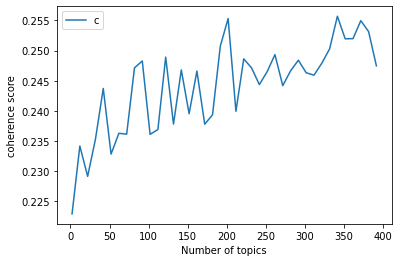

In [ ]:
def compute_coherence(dictionary,doc_term_matrix,doc_clean,stop,start=2,step=5):
    coherence_values = []
    model_list = []
    for num_topics in range(start,stop,step):
        model = LdaModel(doc_term_matrix,num_topics=num_topics,id2word = dictionary)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model,texts=doc_clean,dictionary = dictionary,coherence = 'c_v')
        coherence_values.append(coherence_model.get_coherence())
    return model_list,coherence_values

model_list,coherence_values = compute_coherence(dictionary3,corpus3,texts3,300)
x = range(2,300,5)
plt.plot(x,coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("coherence score")
plt.legend(("coherence_values"),loc = 'best')
plt.show()


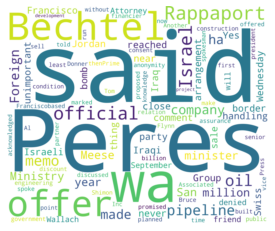

In [ ]:
wordcloud = WordCloud(stopwords=STOPWORDS,max_words=100,
                      background_color='white',min_font_size=6,
                      width=3000,collocations=False,
                      height=2500).generate(df2.story[0])


# Display the generated image:
plt.figure() 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
lda3(corpus3,dictionary3)

(0, '0.069*"the" + 0.027*"of" + 0.024*"to" + 0.022*"and" + 0.020*"a" + 0.014*"in" + 0.011*"it" + 0.009*"said" + 0.008*"on" + 0.008*"for" + 0.007*"that" + 0.007*"is" + 0.007*"by" + 0.006*"wa" + 0.005*"million" + 0.005*"he" + 0.004*"year" + 0.004*"at" + 0.004*"they" + 0.004*"ruby"')
(1, '0.000*"with" + 0.000*"ellemannjensen" + 0.000*"embrace" + 0.000*"missed" + 0.000*"surge" + 0.000*"am" + 0.000*"anasazis" + 0.000*"chased" + 0.000*"rentschler" + 0.000*"muhammad" + 0.000*"blurred" + 0.000*"hypocrisy" + 0.000*"spaeth" + 0.000*"listen" + 0.000*"jockeyed" + 0.000*"dioxide" + 0.000*"flyby" + 0.000*"lockerbie" + 0.000*"stork" + 0.000*"mulligan"')
(2, '0.026*"corn" + 0.017*"farmer" + 0.016*"the" + 0.014*"hasselbring" + 0.014*"acre" + 0.013*"his" + 0.013*"yield" + 0.010*"crop" + 0.009*"contest" + 0.008*"bushel" + 0.007*"you" + 0.007*"hasselbrings" + 0.006*"farmers" + 0.006*"harvest" + 0.005*"campen" + 0.005*"gutwein" + 0.005*"illinois" + 0.005*"per" + 0.005*"herd" + 0.005*"growing"')
(3, '0.016*

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
